<a href="https://colab.research.google.com/github/rzazyx/Prediction-Model/blob/main/Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM STATEMENT

Kekhawatiran adanya keterlambatan pembayaran kartu kredit pada FinanKu yang akan merugikan bisnis. Sehingga orang-orang yang memiliki potensi untuk mengalami keterlambatan bayar bisa diprediksi lebih cepat untuk menentukan strategi yang sesuai dalam menghadapi kondisi di masa mendatang.

# OBJECTIVE

Membuat sebuah model yang dapat memprediksi setidaknya 60% dari pelanggan yang akan mengalami telat bayar kartu kredit [Accuracy & Recall di atas 60%]

# VARIABEL YANG TERSEDIA

1. Customer ID: Unique ID Customer
2. Branch: Lokasi Cabang Nasabah Terdaftar
3. City: Lokasi Kota Nasabah Terdaftar
4. Age: Umur Nasabah Pada Periode Observasi
5. Avg. Annual Income/Month: Rata-rata penghasilan nasabah dalam satu tahun
6. Balance (Q1-Q4): Saldo mengendap yang dimiliki nasabah di akhir kuartal
7. Num of Products (Q1-Q4): Jumlah kepemilikan produk nasabah di akhir kuartal
8. HasCrCard (Q1-Q4): Status kepemilikan produk kartu kredit nasabah di akhir kuartal
9. Active Member (Q1-Q4): Status keaktifan nasabah
10. Unpaid Tagging: Status nasabah gagal bayar

# EXPERIMENT

Periode Tinjauan:
1. Nasabah direview selama satu tahun terakhir
2. Nasabah direview selama 6 bulan terakhir

Penyesuaian Variabel:
1. Balance dilihat dari rata-rata selama horizon waktu & dilihat perubahan pada akhir tinjauan dan awal tinjauan
2. Melihat kepemilikan jumlah produk dari rata-rata, maksimum, dan minimum pada periode tinjauan
3. Status keaktifan nasabah dilihat dalam bentuk bulan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
!pip install jcopml

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer,accuracy_score,precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from jcopml.feature_importance import mean_score_decrease

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
path_1 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20All.csv"
path_2 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20Validasi.csv"
df_all = pd.read_csv(path_1)
df_val = pd.read_csv(path_2)

In [6]:
df1 = pd.read_csv(path_1)
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


In [7]:
df2 = pd.read_csv(path_1)
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


Sebaran Nasabah Berdasarkan Sebaran Keseluruhan dan Nasabah Gagal Bayar

In [8]:
data1 = pd.DataFrame(\
                     #Berdasarkan Kota
                     df_all.groupby(by=["City"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mengurutkan data
                     .sort_values(ascending=False)\
                     #Mereset nama header
                     .reset_index(name='Distribution by City'))
data1

,City,Distribution by City
0,Surabaya,3767
1,Bandung,1898
2,Jakarta,1896


In [9]:
data2 = pd.DataFrame(\
                     #Berdasarkan Kota
                     df_all[df_all["Unpaid Tagging"]==1].groupby(by=["City"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mengurutkan data
                     .sort_values(ascending=False)\
                     #Mereset nama header
                     .reset_index(name='Distribution by City'))
data2

,City,Distribution by City
0,Surabaya,1033
1,Bandung,496
2,Jakarta,490


Sebaran Nasabah Berdasarkan Usia

<Axes: title={'center': 'Cust. Distribution by Age'}, xlabel='Age', ylabel='# People'>

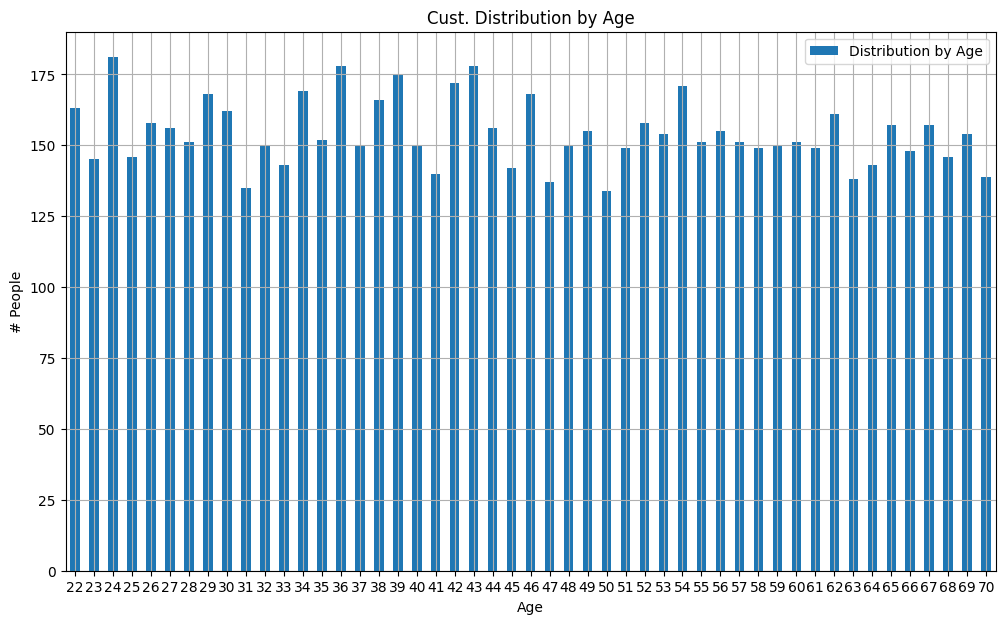

In [10]:
data3 = pd.DataFrame(\
                     #Mengkelompokkan Berdasarkan Umur
                     df_all.groupby(by=["Age"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mereset nama header
                     .reset_index(name='Distribution by Age'))

data3.sort_values(\
                  by=['Age'], \
                  ascending=True,\
                  inplace=True)


data3.plot(x='Age',
           y='Distribution by Age',
           kind='bar',
           grid=True,
           xlabel='Age',
           ylabel='# People',
           figsize=(12, 7),
           rot=0,
           title='Cust. Distribution by Age',
           table=False,
           secondary_y=False)

<Axes: title={'center': 'Unpaid Cust. Distribution by Age'}, xlabel='Age', ylabel='# People'>

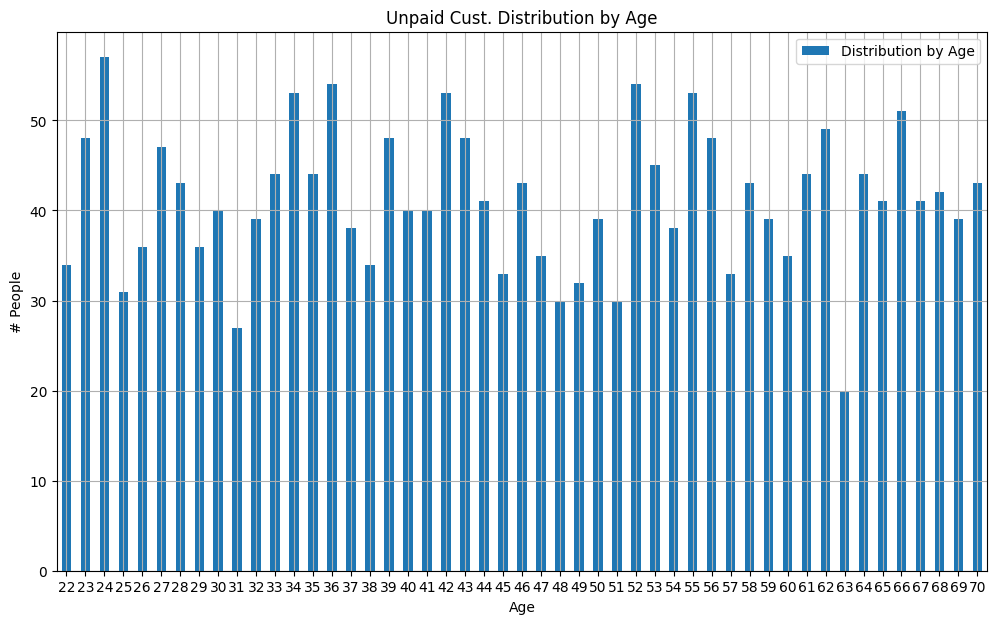

In [11]:
data4 = pd.DataFrame(\
                     #Mengkelompokkan Berdasarkan Umur
                     df_all[df_all["Unpaid Tagging"]==1].groupby(by=["Age"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mereset nama header
                     .reset_index(name='Distribution by Age'))

data4.sort_values(\
                  by=['Age'], \
                  ascending=True,\
                  inplace=True)


data4.plot(x='Age',
           y=['Distribution by Age'],
           kind='bar',
           grid = True,
           xlabel = 'Age',
           ylabel = '# People',
           figsize=(12,7),
           rot = 0,
           title = 'Unpaid Cust. Distribution by Age',
           table = False,
           secondary_y = False)

Rata rata saldo nasabah

In [12]:
df_checkbalance = df_all

In [13]:
df_checkbalance['Total Balance'] = df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4']
df_checkbalance['Avg Balance'] = (df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4'])/4

In [14]:
data5 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Total Balance"]\
                     .mean()\
                     .reset_index(name='Avg Annual Balance'))
data5

,Unpaid Tagging,Avg Annual Balance
0,0,1.985924e+08
1,1,2.527238e+08


In [15]:
data6 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Avg Balance"]\
                     .mean()\
                     .reset_index(name='Avg Quarterly Balance'))
data6

,Unpaid Tagging,Avg Quarterly Balance
0,0,4.964809e+07
1,1,6.318095e+07


rata rata kepemilikan produk

In [16]:
df_checkbalance['Avg Product'] = (df_checkbalance['NumOfProducts Q1']+df_checkbalance['NumOfProducts Q2']+df_checkbalance['NumOfProducts Q3']+df_checkbalance['NumOfProducts Q4'])/4

In [17]:
data7 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Avg Product"]\
                     .mean()\
                     .reset_index(name='Avg Product Owned'))
data7

,Unpaid Tagging,Avg Product Owned
0,0,1.667223
1,1,1.609336


In [18]:
df_all = df_all.drop(columns=['Total Balance', 'Avg Balance','Avg Product'])

Cek duplikat dan missing data

In [19]:
df_all.duplicated().sum()

0

In [20]:
df_all.isnull().sum()

Customer ID                 0
Branch Code                 0
City                        0
Age                         0
Avg. Annual Income/Month    0
Balance Q1                  0
NumOfProducts Q1            0
HasCrCard Q1                0
ActiveMember Q1             0
Balance Q2                  0
NumOfProducts Q2            0
HasCrCard Q2                0
ActiveMember Q2             0
Balance Q3                  0
NumOfProducts Q3            0
HasCrCard Q3                0
ActiveMember Q3             0
Balance Q4                  0
NumOfProducts Q4            0
HasCrCard Q4                0
ActiveMember Q4             0
Unpaid Tagging              0
dtype: int64

Rata rata Saldo & Perubahan Saldo Selama Periode Observasi

Experiment 1: Rata-rata saldo nasabah dalam 1 tahun terakhir & Perubahan Saldo di Q4 terhadap Q1
Experiment 2: Rata-rata saldo nasabah dalam 6 bulan terakhir & Perubahan Saldo di Q4 terhadap Q2

In [21]:
df1['Mean Balance'] = (df1['Balance Q1']+df1['Balance Q2']+df1['Balance Q3']+df1['Balance Q4'])/4
df1['Delta Balance'] = df1['Balance Q4']-df1['Balance Q1']

In [22]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68


In [23]:
df2['Mean Balance'] = (df2['Balance Q3']+df2['Balance Q4'])/2
df2['Delta Balance'] = df2['Balance Q4']-df2['Balance Q2']

In [24]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68


Status Keaktifan

Experiment 1 --> Keaktifan nasabah (dalam bulan) di 1 tahun terakhir

Experiment 2 --> Keaktifan nasabah (dalam bulan) di 6 bulan terakhir


In [25]:
df1['Active Months'] = (df1['ActiveMember Q1']+df1['ActiveMember Q2']+df1['ActiveMember Q3']+df1['ActiveMember Q4'])*3

In [26]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6


In [27]:
df2['Active Months'] = (df2['ActiveMember Q3']+df2['ActiveMember Q4'])*3
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6


Melihat fluktuasi kepemilikan produk nasabah dalam periode observasi

In [28]:
df1['Diff PH'] = df1['NumOfProducts Q4']-df1['NumOfProducts Q1']
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0


In [29]:
df2['Diff PH'] = df2['NumOfProducts Q4']-df1['NumOfProducts Q2']
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6,0


Lama Kepemilikan Kartu Kredit Dalam Periode Observasi

In [30]:
def assign_cr1(df):
    if df['HasCrCard Q1'] == 1:
        return 12
    elif df['HasCrCard Q2'] == 1:
        return 9
    elif df['HasCrCard Q3'] == 1:
        return 6
    else:
        return 3
    return np.nan

In [31]:
df1['Vintage_CR'] = df1.apply(assign_cr1, axis = 1)
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0,12


In [32]:
df2['Vintage_CR'] = df2.apply(assign_cr1, axis = 1)
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6,0,12


Status kepemilikan digantikan dengan lama kepemilikan kartu kredit

In [33]:
df1 = df1.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])
df2 = df2.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])

Balance per quarter digantikan dengan rata rata saldo dalam periode observasi dan selisih saldo awal dan akhir periode observasi

In [34]:
df1 = df1.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'])
df2 = df2.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'])

Jumlah kepemilikan produk digantikan dengan fluktasi kepemilikan produk pada periode observasi

In [35]:
df1 = df1.drop(columns = ['NumOfProducts Q1', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])
df2 = df2.drop(columns = ['NumOfProducts Q1', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])

Status keaktifan nasabah per quarter digantikan dengan status keaktifan dalam bulan

In [36]:
df1 = df1.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2 = df2.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])

Pemisahan variable prediktor

In [37]:
predictor1 = df1[df1.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2 = df2[df2.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,6,29,33000000,1001,Jakarta,1187036.18,0,296759.045,12
1,3,68,17000000,1005,Jakarta,0.00,0,0.000,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,337955.060,12
3,3,42,19000000,1008,Jakarta,0.00,0,0.000,12
4,6,43,29000000,1009,Jakarta,431190.68,0,277524.090,12


In [38]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,3,29,33000000,1001,Jakarta,1187036.18,0,593518.09,12
1,0,68,17000000,1005,Jakarta,0.00,0,0.00,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,675910.12,12
3,0,42,19000000,1008,Jakarta,0.00,0,0.00,12
4,6,43,29000000,1009,Jakarta,431190.68,0,555048.18,12


Encoding untuk data category
1. Branch code
2. City

In [39]:
predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)

<ipython-input-39-b9748522fe9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
<ipython-input-39-b9748522fe9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)


In [40]:
predictor1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [41]:
predictor2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [42]:
predictor1 = pd.get_dummies(predictor1)
predictor2 = pd.get_dummies(predictor2)
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1187036.18,0,296759.045,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,3,68,17000000,0.00,0,0.000,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,337955.060,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,3,42,19000000,0.00,0,0.000,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,277524.090,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [43]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,3,29,33000000,1187036.18,0,593518.09,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.00,0,0.00,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,675910.12,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.00,0,0.00,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,555048.18,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [44]:
predname = predictor1.columns
predname_num = predictor1.columns[0:7]
predname_cat = predictor1.columns[7:31]

In [45]:
predname

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR', 'Branch Code_1001',
       'Branch Code_1002', 'Branch Code_1003', 'Branch Code_1004',
       'Branch Code_1005', 'Branch Code_1006', 'Branch Code_1007',
       'Branch Code_1008', 'Branch Code_1009', 'Branch Code_1011',
       'Branch Code_1012', 'Branch Code_1013', 'Branch Code_1014',
       'Branch Code_1015', 'Branch Code_1021', 'Branch Code_1022',
       'Branch Code_1023', 'Branch Code_1024', 'City_Bandung', 'City_Jakarta',
       'City_Surabaya'],
      dtype='object')

In [46]:
predname_num

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR'],
      dtype='object')

In [47]:
predname_cat

Index(['Branch Code_1001', 'Branch Code_1002', 'Branch Code_1003',
       'Branch Code_1004', 'Branch Code_1005', 'Branch Code_1006',
       'Branch Code_1007', 'Branch Code_1008', 'Branch Code_1009',
       'Branch Code_1011', 'Branch Code_1012', 'Branch Code_1013',
       'Branch Code_1014', 'Branch Code_1015', 'Branch Code_1021',
       'Branch Code_1022', 'Branch Code_1023', 'Branch Code_1024',
       'City_Bandung', 'City_Jakarta', 'City_Surabaya'],
      dtype='object')

In [48]:
X1_num = predictor1[predname_num]
X2_num = predictor2[predname_num]
X1_cat = predictor1[predname_cat]
X2_cat = predictor2[predname_cat]

Standardidasi data numerik

In [49]:
from sklearn.preprocessing import StandardScaler
pt = StandardScaler()
X1_num = pd.DataFrame(pt.fit_transform(X1_num))
X1_num.head()

,0,1,2,3,4,5,6
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [50]:
X1_num.columns = predname_num
X1_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [51]:
X2_num = pd.DataFrame(pt.fit_transform(X2_num))
X2_num.head()

,0,1,2,3,4,5,6
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [52]:
X2_num.columns = predname_num
X2_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


Menggabungkan dataset prediktor

In [53]:
X1 = pd.concat([X1_cat, X1_num], axis = 1)
X2 = pd.concat([X2_cat, X2_num], axis = 1)


In [54]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [55]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [56]:
y1 = df1['Unpaid Tagging']
y2 = df2['Unpaid Tagging']

In [57]:
df1_val = pd.read_csv(path_2)
df2_val = pd.read_csv(path_2)

In [58]:
df1_val.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0


In [59]:
df2_val.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0


Rata rata balance dan perubahan saldo

In [60]:
df1_val['Mean Balance'] = (df1_val['Balance Q2']+df1_val['Balance Q3']+df1_val['Balance Q4']+df1_val['Balance Q5'])/4
df2_val['Mean Balance'] = (df2_val['Balance Q4']+df1_val['Balance Q5'])/2

In [61]:
df1_val['Delta Balance'] = df1_val['Balance Q5']-df1_val['Balance Q2']
df2_val['Delta Balance'] = df2_val['Balance Q5']-df2_val['Balance Q3']

Status keaktifan

In [62]:
df1_val['Active Months'] = (df1_val['ActiveMember Q2']+df1_val['ActiveMember Q3']+df1_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3
df2_val['Active Months'] = (df2_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3

Penambahan atau pengurangan product holding

In [63]:
df1_val['Diff PH'] = df1_val['NumOfProducts Q5']-df1_val['NumOfProducts Q2']
df2_val['Diff PH'] = df2_val['NumOfProducts Q5']-df1_val['NumOfProducts Q3']

Lama kepemilikan kartu

In [64]:
def assign_cr2(df):
    if df['HasCrCard Q2'] == 1:
        return 12
    elif df['HasCrCard Q3'] == 1:
        return 9
    elif df['HasCrCard Q4'] == 1:
        return 6
    else:
        return 3
    return np.nan

In [65]:
df1_val['Vintage_CR'] = df1_val.apply(assign_cr2, axis = 1)
df2_val['Vintage_CR'] = df2_val.apply(assign_cr2, axis = 1)

Penghapusan variabel

In [66]:
df1_val = df1_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4','Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4','NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4','ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2_val = df2_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4','Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4','NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4','ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])

In [67]:
df1_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,6.231940e+05,1.305740e+06,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,7.435011e+05,1.622184e+06,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,3.853218e+05,4.311907e+05,6,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.647607e+07,1.365946e+07,9,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.234332e+08,5.441502e+07,9,2,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.247047e+05,2.996062e+05,3,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.243379e+07,1.169147e+07,9,0,6


In [68]:
df2_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,1.246388e+06,1.305740e+06,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,1.487002e+06,1.622184e+06,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,4.311907e+05,-2.477150e+05,3,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.990946e+07,1.338732e+07,6,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.370369e+08,5.481477e+07,3,1,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.996062e+05,0.000000e+00,0,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.535666e+07,1.191023e+07,3,0,6


Pemilihan variabel prediktor

In [69]:
predictor1_val = df1_val[df1_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2_val = df2_val[df2_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [70]:
predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)

<ipython-input-70-2d4929c2aa9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
<ipython-input-70-2d4929c2aa9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)


In [71]:
predictor1_val = pd.get_dummies(predictor1_val)
predictor2_val = pd.get_dummies(predictor2_val)

In [72]:
predictor1_val.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1305739.798,0,623193.9945,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.000,0,0.0000,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,6,25,12000000,1622184.288,0,743501.1320,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.000,2,0.0000,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.680,1,385321.7600,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [73]:
X1_num_val = predictor1_val[predname_num]
X2_num_val = predictor2_val[predname_num]
X1_cat_val = predictor1_val[predname_cat]
X2_cat_val = predictor2_val[predname_cat]

In [74]:
X1_num_val = pd.DataFrame(pt.fit_transform(X1_num_val))
X1_num_val.columns = predname_num

X2_num_val = pd.DataFrame(pt.fit_transform(X2_num_val))
X2_num_val.columns = predname_num

In [75]:
X1_val = pd.concat([X1_cat, X1_num], axis = 1)
X2_val = pd.concat([X2_cat, X2_num], axis = 1)

In [76]:
X1_val.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [77]:
y1_val = df1_val['Unpaid Tagging']
y2_val = df2_val['Unpaid Tagging']

Variabel yang berkorelasi lebih dari 0.7 akan di drop

In [78]:
corrtest1 = X1.corr().abs()
corrtest2 = X2.corr().abs()

In [79]:
corrtest1

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.000365,0.010394,0.003603,0.001462,0.003888,0.009732,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.007664,0.006371,0.016078,0.004592,0.003957,0.005634,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.018168,0.013724,0.001937,0.008577,0.004227,0.001776,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.001120,0.008420,0.002095,0.015427,0.001172,0.013269,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.011655,0.001335,0.008829,0.010599,0.001569,0.007520,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,0.038095,0.037889,0.036740,0.036048,0.061989,0.060229,0.061056,0.062841,0.094442,0.281983,0.162551,0.006704,0.004534,0.007488,0.000112,0.017499,0.004003,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,0.038591,0.038383,0.037219,0.036517,0.062796,0.061013,0.061851,0.063659,0.095672,0.285654,0.164668,0.010148,0.011408,0.024003,0.002511,0.018648,0.006408,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,0.038886,0.038676,0.037503,0.036796,0.063276,0.061479,0.062323,0.064146,0.096403,0.287836,0.165926,0.000426,0.005992,0.000678,0.003350,0.006413,0.001808,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.002480,0.002933,0.012510,0.001391,0.012129,0.005874,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,0.055410,0.055110,0.053439,0.052431,0.090163,0.087603,0.088806,0.091403,0.409857,0.137270,0.236432,0.001055,0.011252,0.016018,0.025531,0.004062,0.005530,0.020666


In [80]:
corrtest2

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.007562,0.010394,0.003603,0.010657,0.002625,0.009749,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.006371,0.016078,0.001174,0.000411,0.005640,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.013724,0.001937,0.016142,0.007450,0.001736,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.007556,0.008420,0.002095,0.023383,0.007340,0.013205,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.009181,0.001335,0.008829,0.010614,0.003334,0.007493,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,0.038095,0.037889,0.036740,0.036048,0.061989,0.060229,0.061056,0.062841,0.094442,0.281983,0.162551,0.002050,0.004534,0.007488,0.007557,0.002061,0.004017,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,0.038591,0.038383,0.037219,0.036517,0.062796,0.061013,0.061851,0.063659,0.095672,0.285654,0.164668,0.013401,0.011408,0.024003,0.002299,0.018009,0.006425,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,0.038886,0.038676,0.037503,0.036796,0.063276,0.061479,0.062323,0.064146,0.096403,0.287836,0.165926,0.005226,0.005992,0.000678,0.009595,0.012922,0.001792,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.002926,0.002933,0.012510,0.002003,0.022414,0.005889,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,0.055410,0.055110,0.053439,0.052431,0.090163,0.087603,0.088806,0.091403,0.409857,0.137270,0.236432,0.002436,0.011252,0.016018,0.021118,0.012993,0.005449,0.020666


In [81]:
import numpy as np

# Membuang Nilai Redundan Pada Matriks
upper = corrtest1.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))

# Mencari Nilai Yang Berkorelasi di atas 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Menghapus Kolom Yang Berkorelasi di atas 0.7
X1 = X1.drop(to_drop, axis=1)
X1_val = X1_val.drop(to_drop, axis=1)


In [82]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [83]:
# Membuang Nilai Redundan Pada Matriks
upper2 = corrtest2.where(np.triu(np.ones(corrtest2.shape), k=1).astype(bool))

# Mencari Nilai Yang Berkorelasi di atas 0.7
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.7)]

# Menghapus Kolom Yang Berkorelasi di atas 0.7
X2 = X2.drop(to_drop2, axis=1)
X2_val = X2_val.drop(to_drop2, axis=1)

In [84]:
import numpy as np

# Membuang Nilai Redundan Pada Matriks
upper2 = corrtest2.where(np.triu(np.ones(corrtest2.shape), k=1).astype(bool))

# Mencari Nilai Yang Berkorelasi di atas 0.7
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.7)]

# Menghapus Kolom Yang Berkorelasi di atas 0.7
X2 = X2.drop(to_drop2, axis=1)
X2_val = X2_val.drop(to_drop2, axis=1)


In [85]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


Splitting Trian-Test Data

In [86]:
y1.value_counts()

Unpaid Tagging
0    5542
1    2019
Name: count, dtype: int64

In [87]:
y2.value_counts()

Unpaid Tagging
0    5542
1    2019
Name: count, dtype: int64

In [88]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=30)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=30)

Pembangunan model akan menggunakan 3 algoritma:

1. Logistic Regression
2. Gradient Boosting
3. Random Forest

Melakukan Definisi Hyperparameter

In [89]:
penalty = ['l2']
tol = [0.001, 0.0001, 0.00001]
C = [100.0, 10.0, 1.00, 0.1, 0.01, 0.001]
fit_intercept = [True, False]
intercept_scaling = [1.0, 0.75, 0.5, 0.25]
class_weight = ['balanced', None]
solver = ['newton-cg', 'sag', 'lbfgs', 'saga']
max_iter=[14000]
param_distributions = dict(penalty=penalty, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling,
                  class_weight=class_weight, solver=solver, max_iter=max_iter)

Melakukan Pencarian Hyperparameter Terbaik

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [91]:
import time

#cv = cross validation
logreg = LogisticRegression()
grid = GridSearchCV(estimator=logreg, param_grid = param_distributions , scoring = 'recall', cv = 5, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X1_train, y1_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.417563 using {'C': 100.0, 'class_weight': 'balanced', 'fit_intercept': True, 'intercept_scaling': 0.75, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Execution time: 801.8043534755707 s


In [92]:
from sklearn.model_selection import GridSearchCV
import time
logreg = LogisticRegression()
# Assuming logreg, param_distributions, X2_train, and y2_train are already defined
grid2 = GridSearchCV(estimator=logreg, param_grid=param_distributions, scoring='recall', cv=5, n_jobs=-1)
start_time = time.time()
grid_result2 = grid2.fit(X2_train, y2_train)

# Summarize results
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')


Best: 0.394913 using {'C': 100.0, 'class_weight': 'balanced', 'fit_intercept': True, 'intercept_scaling': 0.75, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
Execution time: 771.1106803417206 s


In [93]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer,accuracy_score,precision_score,recall_score,f1_score

In [94]:
gbparameter = {'max_depth':[5,10,15],'gamma':[0.0,0.1,0.2,0.3], 'n_estimators':[25,50,75,100],'learning_rate':[0.05,0.1,0.2,0.3], 'scale_pos_weight':[1,3]}
score = {'accuracy':make_scorer(accuracy_score), 'precision':make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1':make_scorer(f1_score)}

Gamma: nilai minimal loss reduction yang dibutuhkan pada saat pemecahan cabang. Semakin besar nilai gamma yang ditetapkan, model yang dibangun akan lebih konservatif dan memungkinkan terjadinya underfitting.

Learning_rate: tingkat penyesuaian bobot fitur. Dalam pembangunan model, setiap iterasi menghasilkan bobot untuk fitur-fitur yang dimiliki. Learning_rate berguna untuk membantu menyusutkan nilai bobot tersebut agar model yang dibangun tidak mengalami overfitting.

Scale_pos_weight: pengaturan bobot antara kelas positif (churn) dengan kelas negatif (not churn). Hyperparameter ini sangat berguna ketika dataset yang digunakan merupakan imbalance datasets. Nilai yang biasa digunakan yaitu jumlah dari majority class dibagi dengan jumlah minority class.

In [95]:
GB_Grid = GridSearchCV(XGBClassifier(), gbparameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [96]:
start_time = time.time()
GB_result = GB_Grid.fit(X1_train, y1_train)
# Summarize results
print("Best: %f using %s" % (GB_result.best_score_, GB_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.573270 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 3}
Execution time: 370.41899967193604 s


In [97]:
GB_Grid2 = GridSearchCV(XGBClassifier(), gbparameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [98]:
start_time = time.time()
GB2_result = GB_Grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (GB2_result.best_score_, GB2_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.479177 using {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 3}
Execution time: 351.4433069229126 s


Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
parameter = {'max_depth':[5,10,15,20],'max_features':['auto','sqrt','log2'], 'n_estimators':[25,50,75,100,125],'min_samples_split':[2,3,5,7]}
score = {'accuracy':make_scorer(accuracy_score), 'precision':make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1':make_scorer(f1_score)}

Max_depth: jumlah maksimal pemecahan cabang atau level dalam satu pohon. Semakin besar nilai max_depth yang ditetapkan, model akan semakin presisi dalam menggolongkan data ke suatu kelas. Akan tetapi semakin besar nilai max_depth juga akan membuat model overfitting.

Max_features: jumlah maksimal fitur yang dipertimbangkan ketika melakukan pemecahan cabang (splitting node). Sama halnya dengan max_depth¸ semakin banyak jumlah fitur yang dipertimbangkan dalam pemecahan cabang, akan semakin detail hasil yang didapatkan tetapi juga akan membuat model overfitting terhadap data trainingnya.

N_estimator: jumlah pohon yang akan dibangun. Semakin banyak pohon, tingkat akurasi yang didapatkan menjadi lebih baik mengingat Random Forest menggunakan konsep majority vote dalam melakukan klasifikasi. Akan tetapi semakin banyak pohon yang dibangun, waktu komputasi yang dibutuhkan juga akan semakin tinggi.

Min_sample_split: jumlah sampel data minimal pada sebuah internal node. Nilai yang besar dapat membuat model yang dibangun lebih konservatif. Akan tetapi, jika terlalu besar dapat menyebabkan model yang dibangun underfitting.

In [101]:
RF_Grid = GridSearchCV(RandomForestClassifier(), parameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [102]:
start_time = time.time()
RF_result = RF_Grid.fit(X1_train, y1_train)
# Summarize results
print("Best: %f using %s" % (RF_result.best_score_, RF_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best: 0.322033 using {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 25}
Execution time: 309.0171694755554 s


In [103]:
RF_Grid2 = GridSearchCV(RandomForestClassifier(), parameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [104]:
start_time = time.time()
RF_result2 = RF_Grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (RF_result2.best_score_, RF_result2.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
314 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

Best: 0.315650 using {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 25}
Execution time: 308.67897844314575 s


In [105]:
y1_pred =grid.predict(X1_test)

In [108]:
from sklearn import metrics

# Print accuracy and recall scores
print("Accuracy:", metrics.accuracy_score(y1_test, y1_pred))
print("Recall:", metrics.recall_score(y1_test, y1_pred))

# Assuming you want to use other relevant classification metrics
print("Precision:", metrics.precision_score(y1_test, y1_pred))
print("F1 Score:", metrics.f1_score(y1_test, y1_pred))


Accuracy: 0.7765535478184222
Recall: 0.43564356435643564
Precision: 0.6153846153846154
F1 Score: 0.510144927536232


In [109]:
y1_pred_val =grid.predict(X1_val)

In [110]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val, y1_pred_val))
print("Recall:",metrics.recall_score(y1_val, y1_pred_val))
metrics.completeness_score

Accuracy: 0.6384076180399418
Recall: 0.262827611664821


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

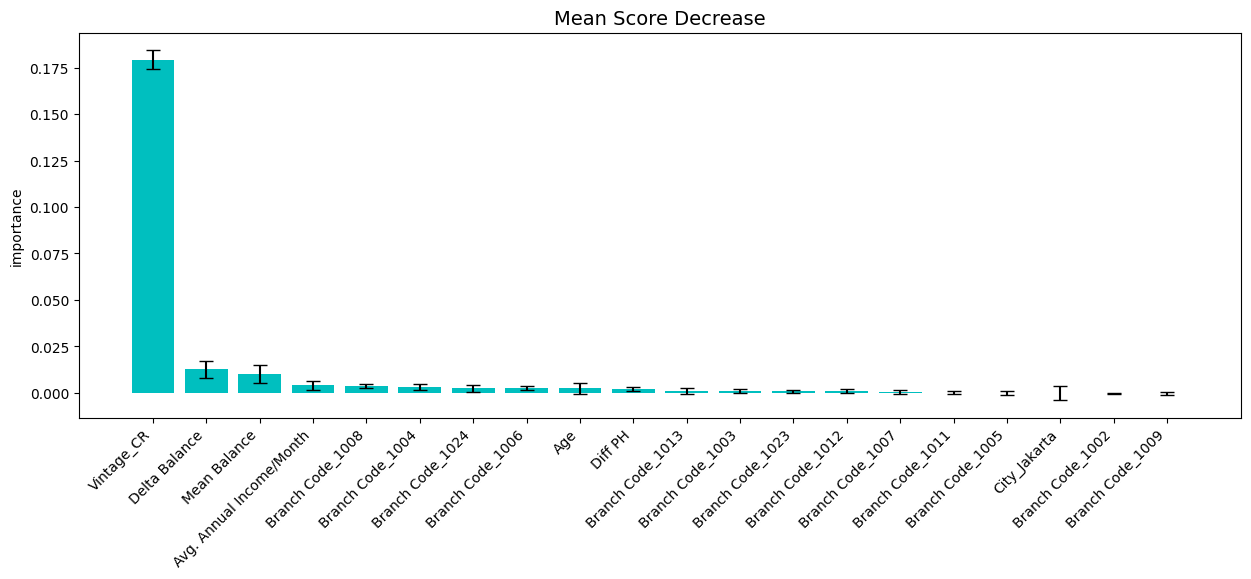

In [111]:
from jcopml.feature_importance import mean_score_decrease
df_imp1 = mean_score_decrease(X1_train, y1_train, grid, plot= True, topk=20)

In [112]:
y2_pred =grid2.predict(X2_test)

In [113]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test, y2_pred))
print("Recall:",metrics.recall_score(y2_test, y2_pred))
metrics.completeness_score

Accuracy: 0.7602468047598061
Recall: 0.4141914191419142


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [114]:
y2_pred_val =grid2.predict(X2_val)

In [115]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val, y2_pred_val))
print("Recall:",metrics.recall_score(y2_val, y2_pred_val))
metrics.completeness_score

Accuracy: 0.6365560111096416
Recall: 0.24584717607973422


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

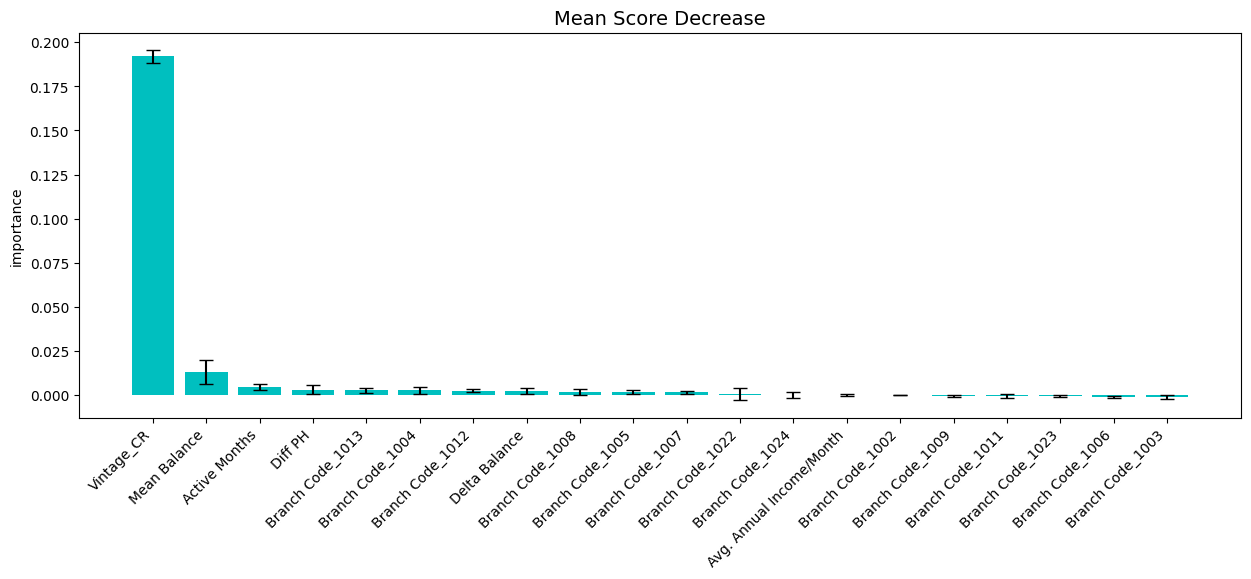

In [116]:
df_imp2 = mean_score_decrease(X2_train, y2_train, grid2, plot= True, topk=20)

Gradient Boosting

In [117]:
y11_pred =GB_Grid.predict(X1_test)

In [118]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test, y11_pred))
print("Recall:",metrics.recall_score(y1_test, y11_pred))
metrics.completeness_score

Accuracy: 0.6862053768179814
Recall: 0.6056105610561056


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [119]:
y11_pred_val =GB_Grid.predict(X1_val)

In [120]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val, y11_pred_val))
print("Recall:",metrics.recall_score(y1_val, y11_pred_val))
metrics.completeness_score

Accuracy: 0.5933077635233435
Recall: 0.4485049833887043


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

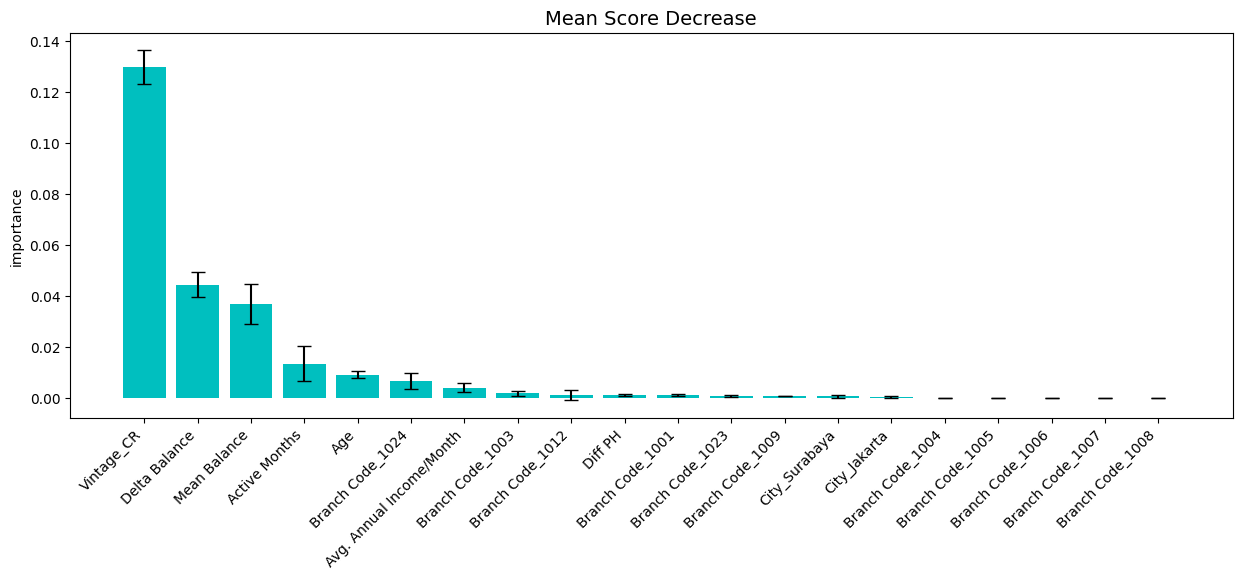

In [121]:
df_imp3 = mean_score_decrease(X1_train, y1_train, GB_Grid, plot= True, topk=20)

In [122]:
y22_pred =GB_Grid2.predict(X2_test)

In [123]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test, y22_pred))
print("Recall:",metrics.recall_score(y2_test, y22_pred))
metrics.completeness_score

Accuracy: 0.7192595857205818
Recall: 0.5066006600660066


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [124]:
y22_pred_val =GB_Grid2.predict(X2_val)

In [125]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val, y22_pred_val))
print("Recall:",metrics.recall_score(y2_val, y22_pred_val))
metrics.completeness_score

Accuracy: 0.6306044174051052
Recall: 0.38870431893687707


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

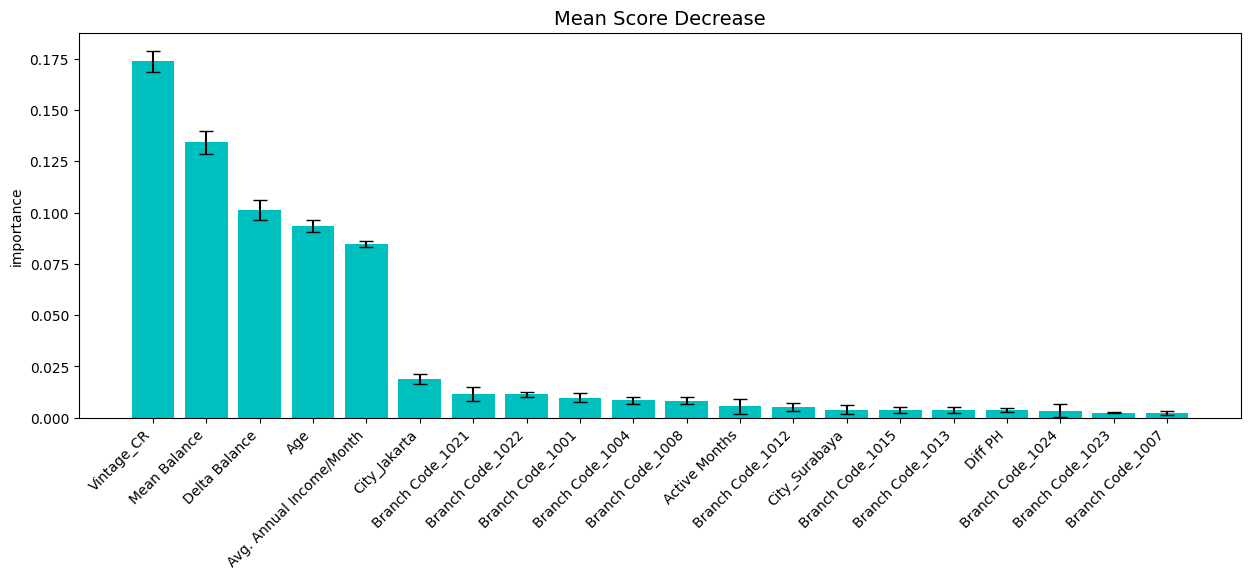

In [126]:
df_imp4 = mean_score_decrease(X2_train, y2_train, GB_Grid2, plot= True, topk=20)

Random Forest

In [127]:
y12_pred =RF_Grid.predict(X1_test)

In [128]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test, y12_pred))
print("Recall:",metrics.recall_score(y1_test, y12_pred))
metrics.completeness_score

Accuracy: 0.8091670339356545
Recall: 0.3217821782178218


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [129]:
y12_pred_val =RF_Grid.predict(X1_val)

In [130]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val, y12_pred_val))
print("Recall:",metrics.recall_score(y1_val, y12_pred_val))
metrics.completeness_score

Accuracy: 0.6910461579156196
Recall: 0.2691029900332226


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

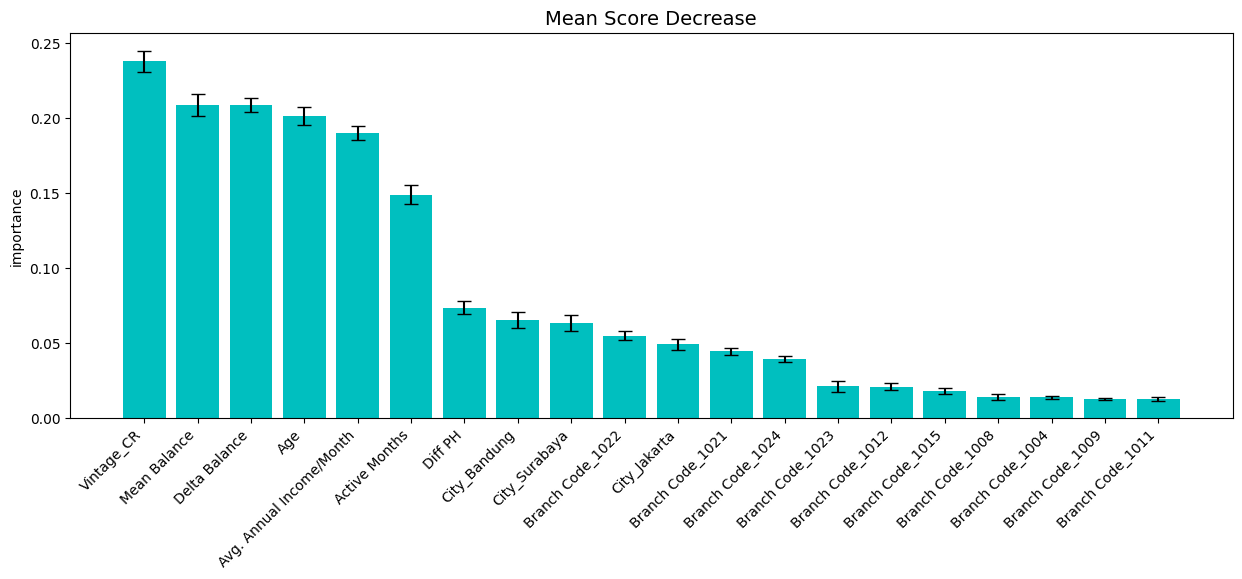

In [131]:
df_imp5 = mean_score_decrease(X1_train, y1_train, RF_Grid, plot= True, topk=20)

In [132]:
y21_pred =RF_Grid2.predict(X2_test)

In [133]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test, y21_pred))
print("Recall:",metrics.recall_score(y2_test, y21_pred))
metrics.completeness_score

Accuracy: 0.8060819744380785
Recall: 0.33003300330033003


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [134]:
y21_pred_val =RF_Grid2.predict(X2_val)

In [135]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val, y21_pred_val))
print("Recall:",metrics.recall_score(y2_val, y21_pred_val))
metrics.completeness_score

Accuracy: 0.7032138606004497
Recall: 0.34551495016611294


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

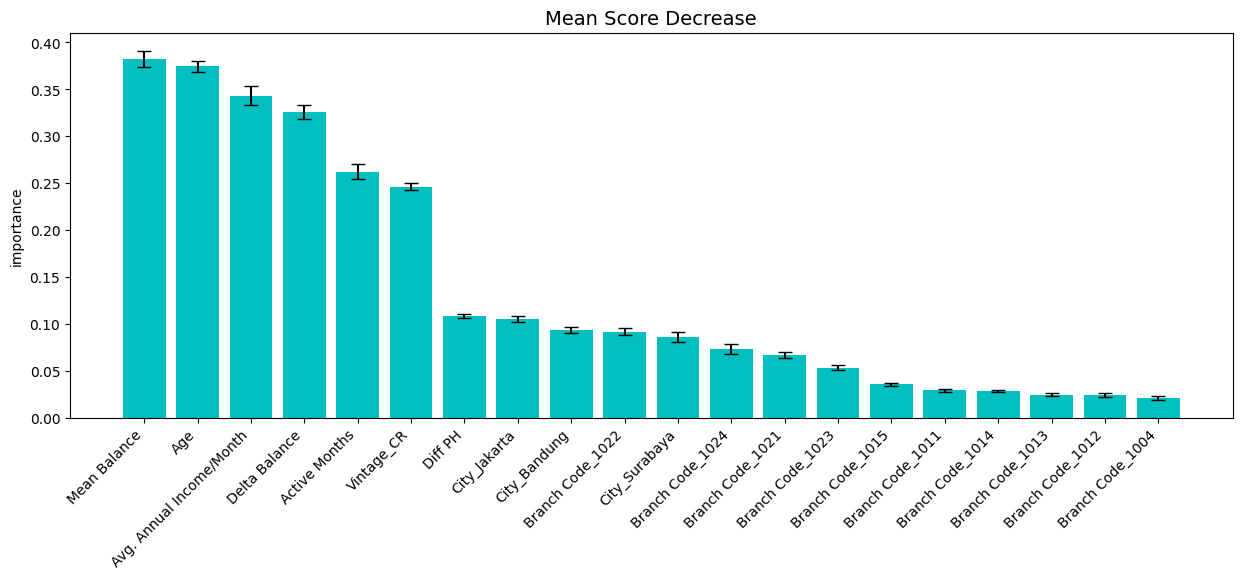

In [136]:
df_imp6 = mean_score_decrease(X2_train, y2_train, RF_Grid2, plot= True, topk=20)

Dari semua model, rata-rata memiliki accuracy di atas 60% namun memiliki recall di bawah 40%. Artinya, masih banyak nasabah yang sebenarnya berpotensi gagal bayar namun diprediksi tidak akan gagal bayar. Sehingga bisa disampaikan bahwa dalam iterasi pembangunan model kali ini, objektif yang diinginkan masih belum dapat tercapai.

Solusi pengembangan kedepannya yang bisa dilakukan di antaranya:

1. Memperbanyak sample (jumlah nasabah dgn asumsi dataset yang tersedia saat ini bukan total populasi nasabah)
2. Melakukan oversampling terhadap kelas minoritas (gagal bayar) agar pembangunan model tidak bias
3. Memperluas horizon waktu
4. Mencoba variasi variabel lainnya (menambah variabel baru, atau membuang variabel yang memiliki nilai importance rendah pada hasil terakhir)
5. Mencoba memperluas kombinasi hyperparameter dalam pembangunan model
6. Mencoba algoritma supervised machine learning lainnya